# Enrichment analysis of proteins realtive to close contacts

Analysis extension to contactanalysis_2D which uses single FOV and averages across the first 10 timepoints taken. 
Follow the installation instructions from contactanalysis_2D readme to set up your virutal environment and install packages. Add the functionality for Jupyter notebooks by running `pip install jupyter`. 

Written by Markus Koerbel. Email mk988@cam.ac.uk

In [20]:
# Import packages

import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import os
from skimage import io, filters, morphology
from scipy import ndimage
import pandas as pd
sns.set_theme(style='ticks')
plt.rcParams['svg.fonttype'] = 'none'

#### For timelapse data, run the following two cells:

In [21]:
# Input Parameters from user for TIRF
pixel_size = 0.106 # um
bias = 400
cell_radius = 20    # px
psf_radius = 1.18   # px
DoG_radius = 50    # px
cell_min_area = 1000 # px
contact_min_area = 6    # px

In [22]:
# function definitions to run code with timepoints (for TIRF data)
def segment_contact(img, sigma, thresh_low, thresh_high, thresh_gauss, min_area, excluded = False):
    if excluded:
        img = np.max(img) - img
    img_gauss = filters.gaussian(img, sigma, preserve_range=True)
    img_div = filters.laplace(img_gauss)
    img_thresh = filters.apply_hysteresis_threshold(img_div, thresh_low, thresh_high)
    img_enh = img_gauss + img_div
    img_thresh_big = img_enh > thresh_gauss
    img_bin = img_thresh | img_thresh_big
    return morphology.remove_small_objects(img_bin, min_area)

def segment_cell(image, s_low, s_high, thresh, min_area):
    '''
    Adapted for single frame from DoG_segmentation from segmentation.py in contactanalysis_2D

    input image is 2 dimensional [x, y]. Bandpass filter applied in spatial (x,y) domain.
    s_low is sigma for Guassian blur of lower spatial frequency cutoff, s_high for higher (s_low > s_high).
    Use two thresholds, one for small contacts, and Otsu threshold for big, bright contacts
    '''
    # Detect presence of small features with DoG
    image_low = filters.gaussian(image, sigma = (s_low,s_low), preserve_range=True)
    image_high = filters.gaussian(image, sigma = (s_high,s_high), preserve_range=True)
    image_bin = np.zeros(image.shape, dtype = bool)
    otsu_thresh = filters.threshold_otsu(image_high)
    image_bin = ((image_high - image_low) > thresh) | (image_high > otsu_thresh)
    image_bin = morphology.remove_small_objects(image_bin, min_size = min_area)
    image_bin = ndimage.binary_fill_holes(image_bin)
    return image_bin

def correlate_contact(folder_tif, folder_ill, ch1, ch2, ch_ill, bias, its_a_cell, DoG_radius, psf_radius, cell_radius, cell_thresh, cell_min_area, contact_thresh_low, contact_thresh_high, contact_thresh_gauss, contact_min_area, ax, finding_parameters = False):
    """
    Do correlation on a contact basis, as segmented by Glycocalyx. Then output size and PCC for each contact. 

    folder_tif contains tif to analyse
    folder_ill contains illumination file
    ch1 is what to correlate, average of 10 frames.
    ch2 is glycocalyx. 
    Glycocalyx used to define contacts. Other channel to define cell. 
    """
    for file in os.listdir(folder_tif):
        if file.endswith(".tif"):
            img1 = np.array(io.imread(os.path.join(folder_tif, file)), dtype = np.int32)
            img1 = img1 - bias
            img1[img1<0] = 1E-6
            if img1.shape[0] < 5:
                return [],[],[]
            img1 = np.mean(img1[:5,:,:,:], axis=0)

    for file in os.listdir(folder_ill):
        if file.endswith(".tif"):
            ill = np.array(io.imread(os.path.join(folder_ill, file)), dtype=np.int32)
            ill = ill - bias
            ill[ill<0] = 1E-6
            ill = np.mean(ill, axis=0)        

    ill_Glyc = ill[:,:,ch_ill]/np.max(ill[:,:,ch_ill])
    corr_Glyc = img1[:,:,ch2]/ill_Glyc
    img_prot = img1[:,:,ch1]

    seg_Glyc = segment_contact(corr_Glyc, psf_radius, contact_thresh_low, contact_thresh_high, contact_thresh_gauss, contact_min_area, excluded=True)
    if its_a_cell:
        seg_prot = segment_cell(img_prot, DoG_radius, psf_radius, cell_thresh, cell_min_area)
        lab_Glyc = ndimage.label(seg_Glyc & seg_prot)[0] 
    else:
        lab_Glyc = ndimage.label(seg_Glyc)[0] 

    if finding_parameters:
        lab_Glyc = ndimage.label(seg_Glyc)[0]

    Glyc_enrichment = []
    Prot_enrichment = []
    Prot_intensities = []
    Prot_img = np.zeros(img_prot.shape)
    if not finding_parameters:
        for ic in np.unique(lab_Glyc[lab_Glyc > 0]): 
            # Dilate each contact by certain radius, then substract the contacts and do inside vs outside analysis
            inside = lab_Glyc == ic
            dilated = morphology.dilation(inside, morphology.disk(10))
            if its_a_cell:
                outside = ((dilated | seg_Glyc) ^ seg_Glyc) & seg_prot
            else:
                outside = (dilated | seg_Glyc) ^ seg_Glyc
            Glyc_enrichment.append(np.mean(corr_Glyc[inside])/np.mean(corr_Glyc[outside]))
            enrich = np.mean(img_prot[inside])/np.mean(img_prot[outside])
            Prot_enrichment.append(enrich)
            Prot_img[inside] += enrich
            Prot_intensities.append(np.mean(img_prot[inside]))
    ax[0].imshow(corr_Glyc, vmin = np.min(corr_Glyc), vmax = np.max(corr_Glyc), cmap='cividis')
    ax[1].imshow(lab_Glyc, cmap='cividis')
    ax[2].imshow(img_prot, vmin = np.min(img_prot), vmax = np.max(img_prot), cmap='cividis')
    if its_a_cell:
        ax[3].imshow(seg_prot, cmap='cividis')  
    [ax[i].set_axis_off() for i in range(4)]

    return Glyc_enrichment, Prot_enrichment, Prot_intensities, Prot_img

#### For single snapshots, run the following two cells:

In [3]:
# Input Parameters from user for confocal
pixel_size = 1/7.589 # um
bias = 0
cell_radius = 20    # px
psf_radius = 1.18   # px
DoG_radius = 50    # px
cell_min_area = 1000 # px
contact_min_area = 6    # px

In [4]:
# for data wihtout timepoints (for confocal data, single snapshot)

# function definitions
def segment_contact(img, sigma, thresh_low, thresh_high, thresh_gauss, min_area, excluded = False):
    if excluded:
        img = np.max(img) - img
    img_gauss = filters.gaussian(img, sigma, preserve_range=True)
    img_div = filters.laplace(img_gauss)
    img_thresh = filters.apply_hysteresis_threshold(img_div, thresh_low, thresh_high)
    img_enh = img_gauss + img_div
    img_thresh_big = img_enh > thresh_gauss
    img_bin = img_thresh | img_thresh_big
    return morphology.remove_small_objects(img_bin, min_area)

def segment_cell(image, s_low, s_high, thresh, min_area):
    '''
    Adapted for single frame from DoG_segmentation from segmentation.py in contactanalysis_2D

    input image is 2 dimensional [x, y]. Bandpass filter applied in spatial (x,y) domain.
    s_low is sigma for Guassian blur of lower spatial frequency cutoff, s_high for higher (s_low > s_high).
    Use two thresholds, one for small contacts, and Otsu threshold for big, bright contacts
    '''
    # Detect presence of small features with DoG
    image_low = filters.gaussian(image, sigma = (s_low,s_low), preserve_range=True)
    image_high = filters.gaussian(image, sigma = (s_high,s_high), preserve_range=True)
    image_bin = np.zeros(image.shape, dtype = bool)
    otsu_thresh = filters.threshold_otsu(image_high)
    image_bin = ((image_high - image_low) > thresh) | (image_high > otsu_thresh)
    image_bin = morphology.remove_small_objects(image_bin, min_size = min_area)
    image_bin = ndimage.binary_fill_holes(image_bin)
    return image_bin

def correlate_contact(folder_tif, folder_ill, ch1, ch2, ch_ill, bias, its_a_cell, DoG_radius, psf_radius, cell_radius, cell_thresh, cell_min_area, contact_thresh_low, contact_thresh_high, contact_thresh_gauss, contact_min_area, ax, finding_parameters = False):
    """
    Do correlation on a contact basis, as segmented by Glycocalyx. Then output size and PCC for each contact. 

    folder_tif contains tif to analyse
    folder_ill contains illumination file
    ch1 is what to correlate, average of 10 frames.
    ch2 is glycocalyx. 
    Glycocalyx used to define contacts. Other channel to define cell. 
    """
    for file in os.listdir(folder_tif):
        if file.endswith(".tif"):
            img1 = np.array(io.imread(os.path.join(folder_tif, file)), dtype = np.int32)
            img1 = img1 - bias
            img1[img1<0] = 1E-6
            if img1.shape[0] < 5:
                return [],[],[] 

    corr_Glyc = img1[:,:,ch2]
    img_prot = img1[:,:,ch1]

    seg_Glyc = segment_contact(corr_Glyc, psf_radius, contact_thresh_low, contact_thresh_high, contact_thresh_gauss, contact_min_area, excluded=True)
    if its_a_cell:
        seg_prot = segment_cell(img_prot, DoG_radius, psf_radius, cell_thresh, cell_min_area)
        lab_Glyc = ndimage.label(seg_Glyc & seg_prot)[0] 
    else:
        lab_Glyc = ndimage.label(seg_Glyc)[0] 

    if finding_parameters:
        lab_Glyc = ndimage.label(seg_Glyc)[0]

    Glyc_enrichment = []
    Prot_enrichment = []
    Prot_intensities = []
    Prot_img = np.zeros(img_prot.shape)
    if not finding_parameters:
        for ic in np.unique(lab_Glyc[lab_Glyc > 0]): 
            # Dilate each contact by certain radius, then substract the contacts and do inside vs outside analysis
            inside = lab_Glyc == ic
            dilated = morphology.dilation(inside, morphology.disk(10))
            if its_a_cell:
                outside = ((dilated | seg_Glyc) ^ seg_Glyc) & seg_prot
            else:
                outside = (dilated | seg_Glyc) ^ seg_Glyc
            Glyc_enrichment.append(np.mean(corr_Glyc[inside])/np.mean(corr_Glyc[outside]))
            enrich = np.mean(img_prot[inside])/np.mean(img_prot[outside])
            Prot_enrichment.append(enrich)
            Prot_img[inside] += enrich
            Prot_intensities.append(np.mean(img_prot[inside]))
    ax[0].imshow(corr_Glyc, vmin = np.min(corr_Glyc), vmax = np.max(corr_Glyc), cmap='cividis')
    ax[1].imshow(lab_Glyc, cmap='cividis')
    ax[2].imshow(img_prot, vmin = np.min(img_prot), vmax = np.max(img_prot), cmap='cividis')
    if its_a_cell:
        ax[3].imshow(seg_prot, cmap='cividis')  
    [ax[i].set_axis_off() for i in range(4)]

    return Glyc_enrichment, Prot_enrichment, Prot_intensities, Prot_img

## Calculate Enrichment: Glycocalyx - protein of interest

Enrichment of protein of interest (e.g. pMHC, TCR, ...) on the SLB relative to close contact zones.

In [ ]:
# The paths need to be adopted to where the data have been saved.
n_fov = 2       # has to be greater 1
folder = 'P:ATH/TO/FOLDER/'
condition = ['Enrichment_images_FOV_{}'.format(i+1) for i in range(n_fov)]  # Image files wihtin 'folder'
illumination = 'Enrichment_imges_illumination'  # Iamage to use for flatfile correction, within 'folder'
channel_order = [2,1,0]         # [ch1-enrich, ch2-glyc, ch_ill-glyc] with the numbering for each channel starting at 0. From FOV file: ch1 shows the protein to calculate enrichment for, ch2 the glycocalyx on the SLB (close contact indicator). From illumination file: ch_ill shows the glycocalyx channel before cell addition. 
its_a_cell = False              # set to True of the protein in ch1 is on the cell, False if on the SLB
cell_thresh = 200               # If its_a_cell = True, threshold for defining the cell area. 
contact_thresh_low = 150        # Lower threshold of the hysteresis threshold for segmenting close contacts
contact_thresh_high = 600       # Higher threshold of the hysteresis threshold for segmenting close contacts
contact_thresh_gauss = 15500    # Threshold for segmenting large contact zones

Glyc_enrichment = []
Prot_enrichment = []
Prot_intensities = []
Prot_img = []

C:\Users\edwar\AppData\Local\Temp\ipykernel_12648\4091156466.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


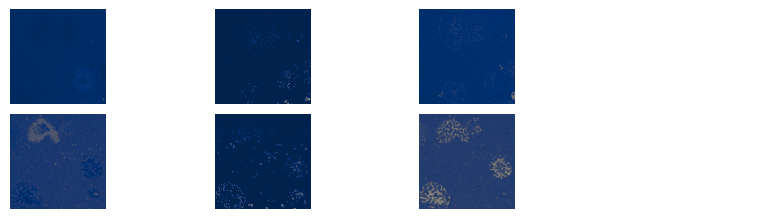

In [16]:
# Runtime ca. 1.5 min for 4 FOV

fig, ax = plt.subplots(n_fov,4, figsize=(8,1*n_fov))
fig.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.1, hspace=0.1)
for fov in range(n_fov):
    Glyc, Prot, Intens, img = correlate_contact(folder+condition[fov], folder+illumination, channel_order[0], channel_order[1], channel_order[2], bias, its_a_cell, DoG_radius, psf_radius, cell_radius, cell_thresh, cell_min_area, contact_thresh_low, contact_thresh_high, contact_thresh_gauss, contact_min_area, ax[fov,:])
    Glyc_enrichment.extend(Glyc)
    Prot_enrichment.extend(Prot)
    Prot_intensities.extend(Intens)
    #Prot_img.append(img)
fig.show()
# The output shows the glycocalyc channel on the SLB, the segmented close contacts, and the protein of interest (pMHC) channel.

In [17]:
#Prot_pMHC_enrichment = Prot1_pMHC_enrichment # For multiple sets of FOVs, ducplicate the two cells above, and adjust the Glyc1/Prot1 variable names to be added here as Prot2_pMHC_enrichment, Prot3_... etc.
print('Number of analysed contacts: {}'.format(len(Prot_enrichment)))

Number of analysed contacts: 668


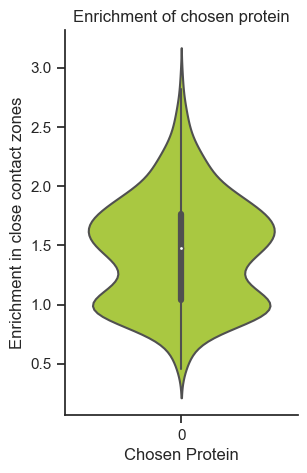

In [18]:
# Plot output graph
fig, ax = plt.subplots(figsize=(3,5))
sns.violinplot(data=Prot_enrichment, color='#b5de2b', ax=ax)
ax.set_ylabel('Enrichment in close contact zones')
ax.set_xlabel('Chosen Protein')
sns.despine()
ax.set_title('Enrichment of chosen protein')
fig.savefig(folder + 'Enrich_protein.svg')

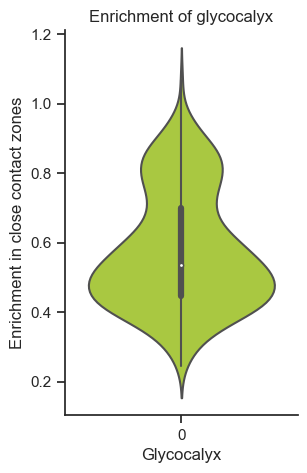

In [19]:
# Plot output graph
fig, ax = plt.subplots(figsize=(3,5))
sns.violinplot(data=Glyc_enrichment, color='#b5de2b', ax=ax)
ax.set_ylabel('Enrichment in close contact zones')
ax.set_xlabel('Glycocalyx')
sns.despine()
ax.set_title('Enrichment of glycocalyx')
fig.savefig(folder + 'Enrich_Glyc.svg')

In [14]:
# Save as .csv in same folder
series = {
    'Protein_enrichment': np.array(Prot_enrichment),
    'Glycocalyx_enrichment': np.array(Glyc_enrichment),
    'Protein_intensities': np.array(Prot_intensities)
}
output = pd.DataFrame(series)
output.to_csv(folder + 'Enrichment_output.csv')